In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install optuna
!pip install openpyxl
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install pandas
!pip install scikit-learn
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.6 MB/s eta 0:00:00
Looking in indexes: https://download.pytorch.org/whl/cu118


In [ ]:
import os

training_dir = '/content/drive/MyDrive/Colab Notebooks/frames/Train48'
training_output_path = '/content/drive/MyDrive/Colab Notebooks/training.xlsx'

validation_dir = '/content/drive/MyDrive/Colab Notebooks/frames/validation48'
val_output_path = '/content/drive/MyDrive/Colab Notebooks/validation.xlsx'

test_dir = '/content/drive/MyDrive/Colab Notebooks/frames/test48'
test_output_path = '/content/drive/MyDrive/Colab Notebooks/testing.xlsx'

def create_dataset_from_directory(folder_path, output_name):
    # Get a list of all files in the directory
    file_list = os.listdir(folder_path)

    # Filter the list to include only .mp4 files
    mp4_files = [f for f in file_list if f.endswith('.mp4')]

    # Initialize lists to store data
    file_names = []
    labels = []
    label_num = []

    # Process each .mp4 file
    for mp4_file in mp4_files:
        # Add the file name to the 'file_names' list
        file_names.append(mp4_file)

        # Extract the substring from the file name
        labels.append(mp4_file.split('-')[-1].split('_')[0])

        # Extract the number from the file name
        label_num.append(int(mp4_file.split('-')[-1].split('_')[0][1]) - 1)

    # Create a DataFrame to store the data
    data = {
        'Filename': file_names,
        'Label': labels,
        'Label_number': label_num
    }
    df = pd.DataFrame(data)

    # Save the DataFrame to an Excel file
    df.to_excel(output_name, index=False)

def count_files(folder_path):
    # Get a list of all files in the directory
    file_list = os.listdir(folder_path)

    # Filter the list to include only .mp4 files
    mp4_files = [f for f in file_list if f.endswith('.mp4')]
    return len(mp4_files)

print(count_files('/content/drive/MyDrive/Colab Notebooks/frames/train48'))

1093


In [ ]:
#All the imports
import cv2
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torchvision import models
import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode
import torch.optim as optim
import time
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
import optuna
from sklearn import metrics
import json
import concurrent.futures

# [GLOBAL VARIABLES]

# Set the random seed for reproducibility
torch.manual_seed(42)

# Pre-trained Model Info
model_name = "MViT_V2_S"

scaler = torch.cuda.amp.GradScaler()

# Video details
video_frame_count = 14
number_of_classes = 9
number_of_channels = 3
width = 224
height = 224

# You might want to change these values to fit your dataset better
transform = transforms.Compose([
    transforms.Resize((width, height), interpolation=InterpolationMode.BICUBIC),  # resize the image to 224 by 224
    transforms.CenterCrop(size=224),  # apply center crop
    transforms.ToTensor(),  # converts the image from a PIL Image object to a PyTorch tensor.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # normalizes the tensor image
])

# Directories of video files and corresponding Excel files with labels.
training_dir = '/content/drive/MyDrive/Colab Notebooks/frames/train48'
training_excel = '/content/drive/MyDrive/Colab Notebooks/training.xlsx'
validation_dir = '/content/drive/MyDrive/Colab Notebooks/frames/validation48'
validation_excel = '/content/drive/MyDrive/Colab Notebooks/validation.xlsx'


# [Classes]

# Loads video datasets into memory while training
class VideoDataset(Dataset):
    def __init__(self, data_dir, excel_file):
        self.data_dir = data_dir  # Video dataset directory
        self.df = pd.read_excel(excel_file, engine="openpyxl")  # Load the Excel file -> pip install openpyxl

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        video_path = os.path.join(self.data_dir, self.df.iloc[idx, 0])  # Get the video file path

        label = int(self.df.iloc[idx, 2])
        frames = preprocess_video(video_path)  # Get the individual frames

        weights = models.get_model_weights(model_name).DEFAULT
        frame_transformer = weights.transforms()
        frames = frame_transformer(frames)

        return frames, label  # Return the frames and labels

# Loads video datasets into memory before training
class VideoRAMDataset(Dataset):
    def __init__(self, data):
        frames_list = []
        labels_list = []

        for frames, label in data:
            frames_list.append(frames)
            labels_list.append(label)

        self.frames = frames_list
        self.labels = labels_list

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        frames = self.frames[idx]

        return frames, label  # Return the frames and labels


# [FUNCTIONS]

def apply_transform(frame):
    # Convert the frame to a PIL Image
    pil_image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    # Apply the specified transformation
    transformed_frame = transform(pil_image)

    return transformed_frame


def preprocess_video(video_path, num_frames=video_frame_count):
    # Initialize an empty list to store frames
    frames = []

    # Open the video file using OpenCV
    video = cv2.VideoCapture(video_path)

    # Initialize the frame index
    frame_index = 0

    while True:
        # Read the next frame from the video
        ret, frame = video.read()

        # Check if there are no more frames to read
        if not ret:
            break

        # Check if we have processed the desired number of frames
        if frame_index == num_frames:
            break

        # Apply a transformation to the frame (custom function)
        transformed_frame = apply_transform(frame)

        # Append the transformed frame to the list of frames
        frames.append(transformed_frame)

        # Increment the frame index
        frame_index += 1

    video.release()

    # Zero pad frames to 16 if necessary
    while len(frames) < 16:
        # Create a black frame
        black_frame = np.zeros((height, width, 3), dtype=np.uint8)
        transformed_frame = apply_transform(black_frame)
        frames.append(transformed_frame)

    # Convert the list of frames to a PyTorch tensor
    frames = torch.stack(frames)

    return frames

def load_data_in_ram(df, data_dir, num_threads=8):
    print(f'Loading data from {data_dir} in RAM')
    start_time = time.time()

    def process_video(idx):
        video_name = df.iloc[idx, 0]
        video_path = os.path.join(data_dir, video_name)  # Get the video file path
        label = int(df.iloc[idx, 2])
        frames = preprocess_video(video_path)  # Get the individual frames

        weights = models.get_model_weights(model_name).DEFAULT
        frame_transformer = weights.transforms()
        frames = frame_transformer(frames)

        return frames, label

    # Use multithreading to load data from multiple videos in parallel
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
        video_indices = range(len(df))
        data = list(executor.map(process_video, video_indices))

    data_time = time.time() - start_time  # Calculate epoch execution time
    print(f'Loaded {len(data)} videos in RAM in {int(data_time)} seconds')

    return data  # Return the frames and labels


def get_data_loaders_ram_before_training(train_data, val_data, hyper_parameters):
    # Create the training and validation datasets
    train_dataset = VideoRAMDataset(train_data)
    val_dataset = VideoRAMDataset(val_data)

    # Create DataLoaders for training and validation
    train_loader = DataLoader(train_dataset, batch_size=hyper_parameters['batch_size'], num_workers=8, pin_memory=True)
    validation_loader = DataLoader(val_dataset, batch_size=hyper_parameters['batch_size'], num_workers=8,
                                   pin_memory=True)

    return train_loader, validation_loader

def get_data_loaders_ram_during_training(hyper_parameters):
    # Create the training and validation datasets
    train_dataset = VideoDataset(training_dir, training_excel)
    val_dataset = VideoDataset(validation_dir, validation_excel)

    # Create DataLoaders for training and validation
    train_loader = DataLoader(train_dataset, batch_size=hyper_parameters['batch_size'], num_workers=8,  pin_memory=True)
    validation_loader = DataLoader(val_dataset, batch_size=hyper_parameters['batch_size'], num_workers=8, pin_memory=True)

    return train_loader, validation_loader


def get_model(dropout, num_hidden_layers, num_neurons):
    # Step 1: Load the pretrained model
    builder = models.get_model_builder(model_name)
    weights = models.get_model_weights(model_name).KINETICS400_V1
    model = builder(weights=weights)

    num_in_features = 400  # Kinetics pre-trained dataset has 400 features

    # Step 2: Define the new classification head
    classifier_layers = []

    for i in range(num_hidden_layers):
        if i == 0:
            in_features = num_in_features
            out_features = num_neurons
        else:
            in_features = num_neurons
            out_features = num_neurons
        # Add linear layer, batch normalization, and dropout
        classifier_layers.extend([
            nn.Linear(in_features, out_features),
            nn.BatchNorm1d(out_features),
            nn.Dropout(p=dropout),
        ])

    # Add the final output layer
    classifier_layers.append(nn.Linear(num_neurons, number_of_classes))

    # Step 3: Replace the final classification head of the model
    model.head.fc = nn.Sequential(*classifier_layers)

    return model


def get_hyperparameters(trial):
    # Get the hyperparameters to optimize
    hyper_parameters = {'batch_size': 8, 'epochs': 10,
                        'optimizer_name': trial.suggest_categorical("optimizer_name", ["AdamW", "SGD"]),
                        'weight_decay': trial.suggest_float("weight_decay", low=0.001, high=0.01, log=True),
                        'learning_rate': trial.suggest_float("learning_rate", low=0.001, high=0.01, log=True),
                        'dropout': trial.suggest_categorical("dropout", [0.25, 0.5]),
                        'num_hidden_layers': trial.suggest_int("num_hidden_layers", low=1, high=1),
                        'num_neurons': trial.suggest_categorical("num_neurons", [256, 512])}

    return hyper_parameters


def train_one_epoch(model, train_dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    running_total = 0

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        running_total += labels.size(0)
        running_corrects += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_dataloader.dataset)
    train_accuracy = 100 * running_corrects / running_total

    return model, train_loss, train_accuracy


def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    loss = 0.0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss += criterion(outputs, labels).item() * labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            #print(predicted)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            y_true += labels.cpu().tolist()
            y_pred += predicted.cpu().tolist()

    accuracy = 100 * correct / total
    loss /= len(dataloader.dataset)
    f1_score = metrics.f1_score(y_true, y_pred, average='macro')

    return model, loss, accuracy, f1_score


def train_model(model, trial, hyper_parameters, optimizer, criterion, train_dataloader, valid_dataloader):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using {device} for training")
    model.to(device)

    print(f"Starting training settings: {hyper_parameters}")

    best_val_loss = float('inf')
    best_f1_score = 0
    patience = 3
    no_improvement_count = 0

    for epoch in range(hyper_parameters['epochs']):
        start_time = time.time()  # Record the start time

        model, train_loss, train_accuracy = train_one_epoch(model, train_dataloader, optimizer, criterion, device)

        model, val_loss, val_accuracy, f1_score = evaluate(model, valid_dataloader, criterion, device)

        epoch_time = time.time() - start_time  # Calculate epoch execution time
        print(f"[Epoch {epoch + 1} {int(epoch_time)}s runtime] Train Loss = {train_loss:.4f}, Train Accuracy = {train_accuracy:.2f}%, Validation Loss = {val_loss:.4f}, Validation Accuracy = {val_accuracy:.2f}%, F1-score = {f1_score:.4f}")

        trial.report(f1_score, epoch)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        if f1_score > best_f1_score:
            best_f1_score = f1_score

        if no_improvement_count >= patience:
            print(f"No improvement after {no_improvement_count} epochs. Stopping training...")
            return best_f1_score

    return best_f1_score


def get_optimizer(model, hyper_parameters):
    # Define the optimizer based on the optimizer_name hyperparameter
    if hyper_parameters['optimizer_name'] == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=hyper_parameters['learning_rate'])
    else:
        optimizer = optim.SGD(model.parameters(), lr=hyper_parameters['learning_rate'],
                              momentum=0.9, nesterov=True, weight_decay=hyper_parameters['weight_decay'])
    return optimizer


def objective(trial, train_data, val_data):
    # Step 1: Retrieve hyperparameters for the trial
    hyper_parameters = get_hyperparameters(trial)

    # Step 2: Get the data loaders for training and validation
    train_dataloader, valid_dataloader = get_data_loaders_ram_before_training(train_data, val_data, hyper_parameters)

    # Step 3: Create the model
    model = get_model(hyper_parameters['dropout'], hyper_parameters['num_hidden_layers'],
                      hyper_parameters['num_neurons'])

    # Step 4: Define the optimizer and loss function based on hyperparameters
    optimizer = get_optimizer(model, hyper_parameters)
    criterion = nn.CrossEntropyLoss()

    # Step 5: Train the model with the specified hyperparameters
    return train_model(model, trial, hyper_parameters, optimizer, criterion, train_dataloader, valid_dataloader)


def find_best_hyperparameters(train_data, val_data):
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(trial, train_data, val_data), n_trials=10)

    pruned_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    # Store the best parameters in a JSON file
    best_params = trial.params
    with open('drive/MyDrive/Colab Notebooks/best_parameters.json', 'w') as f:
        json.dump(best_params, f, indent=4)
        print("Best parameters saved to 'best_parameters.json'")


if __name__ == '__main__':
    # Load the Excel files
    train_df = pd.read_excel(training_excel, engine="openpyxl")
    validation_df = pd.read_excel(validation_excel, engine="openpyxl")

    train_data = load_data_in_ram(train_df, training_dir)
    val_data = load_data_in_ram(validation_df, validation_dir)

    find_best_hyperparameters(train_data, val_data)

Loading data from /content/drive/MyDrive/Colab Notebooks/frames/train48 in RAM
Loaded 1093 videos in RAM in 155 seconds
Loading data from /content/drive/MyDrive/Colab Notebooks/frames/validation48 in RAM


[I 2023-11-06 12:51:09,397] A new study created in memory with name: no-name-03d49074-76dc-455c-be19-5820118d898a


Loaded 131 videos in RAM in 156 seconds


Downloading: "https://download.pytorch.org/models/mvit_v2_s-ae3be167.pth" to /root/.cache/torch/hub/checkpoints/mvit_v2_s-ae3be167.pth
100%|██████████| 132M/132M [00:00<00:00, 178MB/s]


Using cuda for training
Starting training settings: {'batch_size': 8, 'epochs': 10, 'optimizer_name': 'AdamW', 'weight_decay': 0.009386402995983804, 'learning_rate': 0.00517085025967206, 'dropout': 0.25, 'num_hidden_layers': 1, 'num_neurons': 256}
[Epoch 1 71s runtime] Train Loss = 2.5875, Train Accuracy = 13.45%, Validation Loss = 2.3504, Validation Accuracy = 11.45%, F1-score = 0.0228
[Epoch 2 63s runtime] Train Loss = 2.3788, Train Accuracy = 12.53%, Validation Loss = 2.2330, Validation Accuracy = 12.21%, F1-score = 0.0242
[Epoch 3 63s runtime] Train Loss = 2.3727, Train Accuracy = 11.34%, Validation Loss = 2.1943, Validation Accuracy = 12.21%, F1-score = 0.0242
[Epoch 4 63s runtime] Train Loss = 2.2776, Train Accuracy = 12.72%, Validation Loss = 2.1757, Validation Accuracy = 12.21%, F1-score = 0.0242
[Epoch 5 63s runtime] Train Loss = 2.2515, Train Accuracy = 10.89%, Validation Loss = 2.1811, Validation Accuracy = 12.21%, F1-score = 0.0242
[Epoch 6 63s runtime] Train Loss = 2.2549,

[I 2023-11-06 13:00:53,587] Trial 0 finished with value: 0.02418745275888133 and parameters: {'optimizer_name': 'AdamW', 'weight_decay': 0.009386402995983804, 'learning_rate': 0.00517085025967206, 'dropout': 0.25, 'num_hidden_layers': 1, 'num_neurons': 256}. Best is trial 0 with value: 0.02418745275888133.


[Epoch 9 63s runtime] Train Loss = 2.1833, Train Accuracy = 12.08%, Validation Loss = 2.1910, Validation Accuracy = 12.21%, F1-score = 0.0242
No improvement after 3 epochs. Stopping training...
Using cuda for training
Starting training settings: {'batch_size': 8, 'epochs': 10, 'optimizer_name': 'SGD', 'weight_decay': 0.004413653370547514, 'learning_rate': 0.002499326910386128, 'dropout': 0.25, 'num_hidden_layers': 1, 'num_neurons': 512}
[Epoch 1 63s runtime] Train Loss = 2.7437, Train Accuracy = 11.25%, Validation Loss = 2.4612, Validation Accuracy = 11.45%, F1-score = 0.0228
[Epoch 2 62s runtime] Train Loss = 2.7142, Train Accuracy = 10.43%, Validation Loss = 2.2157, Validation Accuracy = 12.21%, F1-score = 0.0242
[Epoch 3 62s runtime] Train Loss = 2.6447, Train Accuracy = 13.36%, Validation Loss = 2.4133, Validation Accuracy = 11.45%, F1-score = 0.0228
[Epoch 4 63s runtime] Train Loss = 2.6201, Train Accuracy = 10.43%, Validation Loss = 2.2278, Validation Accuracy = 11.45%, F1-score 

[I 2023-11-06 13:09:17,294] Trial 1 finished with value: 0.024691358024691357 and parameters: {'optimizer_name': 'SGD', 'weight_decay': 0.004413653370547514, 'learning_rate': 0.002499326910386128, 'dropout': 0.25, 'num_hidden_layers': 1, 'num_neurons': 512}. Best is trial 1 with value: 0.024691358024691357.


[Epoch 8 62s runtime] Train Loss = 2.4909, Train Accuracy = 13.72%, Validation Loss = 2.2334, Validation Accuracy = 12.21%, F1-score = 0.0242
No improvement after 3 epochs. Stopping training...
Using cuda for training
Starting training settings: {'batch_size': 8, 'epochs': 10, 'optimizer_name': 'SGD', 'weight_decay': 0.0017985811871372747, 'learning_rate': 0.005703848306108669, 'dropout': 0.5, 'num_hidden_layers': 1, 'num_neurons': 512}
[Epoch 1 62s runtime] Train Loss = 3.7931, Train Accuracy = 11.71%, Validation Loss = 2.9063, Validation Accuracy = 12.21%, F1-score = 0.0242
[Epoch 2 62s runtime] Train Loss = 3.8714, Train Accuracy = 13.08%, Validation Loss = 3.5172, Validation Accuracy = 12.21%, F1-score = 0.0242
[Epoch 3 62s runtime] Train Loss = 4.0290, Train Accuracy = 12.08%, Validation Loss = 2.5992, Validation Accuracy = 12.21%, F1-score = 0.0242
[Epoch 5 63s runtime] Train Loss = 3.7429, Train Accuracy = 13.08%, Validation Loss = 2.3884, Validation Accuracy = 12.21%, F1-score 

[I 2023-11-06 13:18:43,481] Trial 2 finished with value: 0.02418745275888133 and parameters: {'optimizer_name': 'SGD', 'weight_decay': 0.0017985811871372747, 'learning_rate': 0.005703848306108669, 'dropout': 0.5, 'num_hidden_layers': 1, 'num_neurons': 512}. Best is trial 1 with value: 0.024691358024691357.


[Epoch 9 62s runtime] Train Loss = 3.0115, Train Accuracy = 11.25%, Validation Loss = 2.2371, Validation Accuracy = 12.21%, F1-score = 0.0242
No improvement after 3 epochs. Stopping training...
Using cuda for training
Starting training settings: {'batch_size': 8, 'epochs': 10, 'optimizer_name': 'SGD', 'weight_decay': 0.0030008226240510086, 'learning_rate': 0.0017768745726507078, 'dropout': 0.25, 'num_hidden_layers': 1, 'num_neurons': 512}
[Epoch 1 62s runtime] Train Loss = 2.4904, Train Accuracy = 15.00%, Validation Loss = 2.3466, Validation Accuracy = 13.74%, F1-score = 0.0890
[Epoch 2 62s runtime] Train Loss = 2.0679, Train Accuracy = 31.02%, Validation Loss = 1.8470, Validation Accuracy = 34.35%, F1-score = 0.2961
[Epoch 3 62s runtime] Train Loss = 1.6613, Train Accuracy = 42.27%, Validation Loss = 1.3406, Validation Accuracy = 53.44%, F1-score = 0.4835
[Epoch 4 62s runtime] Train Loss = 1.2934, Train Accuracy = 54.16%, Validation Loss = 1.1779, Validation Accuracy = 54.96%, F1-scor

[I 2023-11-06 13:26:04,573] Trial 3 finished with value: 0.5244478548826375 and parameters: {'optimizer_name': 'SGD', 'weight_decay': 0.0030008226240510086, 'learning_rate': 0.0017768745726507078, 'dropout': 0.25, 'num_hidden_layers': 1, 'num_neurons': 512}. Best is trial 3 with value: 0.5244478548826375.


[Epoch 7 63s runtime] Train Loss = 0.6659, Train Accuracy = 75.30%, Validation Loss = 1.4934, Validation Accuracy = 59.54%, F1-score = 0.5244
No improvement after 3 epochs. Stopping training...
Using cuda for training
Starting training settings: {'batch_size': 8, 'epochs': 10, 'optimizer_name': 'AdamW', 'weight_decay': 0.0016256073314224071, 'learning_rate': 0.0011259323325416735, 'dropout': 0.5, 'num_hidden_layers': 1, 'num_neurons': 512}
[Epoch 1 63s runtime] Train Loss = 2.5858, Train Accuracy = 12.44%, Validation Loss = 2.1817, Validation Accuracy = 12.21%, F1-score = 0.0242
[Epoch 2 63s runtime] Train Loss = 2.4398, Train Accuracy = 11.99%, Validation Loss = 2.1921, Validation Accuracy = 12.21%, F1-score = 0.0242
[Epoch 3 63s runtime] Train Loss = 2.3507, Train Accuracy = 13.91%, Validation Loss = 2.1765, Validation Accuracy = 12.21%, F1-score = 0.0242
[Epoch 4 63s runtime] Train Loss = 2.3381, Train Accuracy = 12.44%, Validation Loss = 2.1662, Validation Accuracy = 12.21%, F1-sco

[I 2023-11-06 13:33:30,391] Trial 4 finished with value: 0.02418745275888133 and parameters: {'optimizer_name': 'AdamW', 'weight_decay': 0.0016256073314224071, 'learning_rate': 0.0011259323325416735, 'dropout': 0.5, 'num_hidden_layers': 1, 'num_neurons': 512}. Best is trial 3 with value: 0.5244478548826375.


[Epoch 7 63s runtime] Train Loss = 2.3819, Train Accuracy = 10.80%, Validation Loss = 2.1702, Validation Accuracy = 11.45%, F1-score = 0.0228
No improvement after 3 epochs. Stopping training...
Using cuda for training
Starting training settings: {'batch_size': 8, 'epochs': 10, 'optimizer_name': 'AdamW', 'weight_decay': 0.001444023128779156, 'learning_rate': 0.005692335646175652, 'dropout': 0.5, 'num_hidden_layers': 1, 'num_neurons': 512}
[Epoch 1 63s runtime] Train Loss = 3.1822, Train Accuracy = 10.70%, Validation Loss = 2.2028, Validation Accuracy = 12.21%, F1-score = 0.0242
[Epoch 2 63s runtime] Train Loss = 2.7840, Train Accuracy = 12.72%, Validation Loss = 2.2637, Validation Accuracy = 11.45%, F1-score = 0.0228
[Epoch 3 63s runtime] Train Loss = 2.9255, Train Accuracy = 11.80%, Validation Loss = 2.2316, Validation Accuracy = 11.45%, F1-score = 0.0228


[I 2023-11-06 13:37:45,587] Trial 5 finished with value: 0.02418745275888133 and parameters: {'optimizer_name': 'AdamW', 'weight_decay': 0.001444023128779156, 'learning_rate': 0.005692335646175652, 'dropout': 0.5, 'num_hidden_layers': 1, 'num_neurons': 512}. Best is trial 3 with value: 0.5244478548826375.


[Epoch 4 63s runtime] Train Loss = 2.7271, Train Accuracy = 12.53%, Validation Loss = 2.2132, Validation Accuracy = 12.21%, F1-score = 0.0242
No improvement after 3 epochs. Stopping training...
Using cuda for training
Starting training settings: {'batch_size': 8, 'epochs': 10, 'optimizer_name': 'AdamW', 'weight_decay': 0.0011436647545676622, 'learning_rate': 0.002339478541121978, 'dropout': 0.25, 'num_hidden_layers': 1, 'num_neurons': 512}
[Epoch 1 63s runtime] Train Loss = 2.6610, Train Accuracy = 12.26%, Validation Loss = 2.1917, Validation Accuracy = 12.21%, F1-score = 0.0242
[Epoch 2 63s runtime] Train Loss = 2.4405, Train Accuracy = 12.99%, Validation Loss = 2.2228, Validation Accuracy = 12.21%, F1-score = 0.0242
[Epoch 3 63s runtime] Train Loss = 2.3863, Train Accuracy = 13.17%, Validation Loss = 2.1689, Validation Accuracy = 12.21%, F1-score = 0.0242
[Epoch 4 63s runtime] Train Loss = 2.3833, Train Accuracy = 12.72%, Validation Loss = 2.2314, Validation Accuracy = 12.21%, F1-sco

[I 2023-11-06 13:44:07,880] Trial 6 finished with value: 0.02418745275888133 and parameters: {'optimizer_name': 'AdamW', 'weight_decay': 0.0011436647545676622, 'learning_rate': 0.002339478541121978, 'dropout': 0.25, 'num_hidden_layers': 1, 'num_neurons': 512}. Best is trial 3 with value: 0.5244478548826375.


[Epoch 6 63s runtime] Train Loss = 2.3420, Train Accuracy = 11.44%, Validation Loss = 2.2836, Validation Accuracy = 12.21%, F1-score = 0.0242
No improvement after 3 epochs. Stopping training...
Using cuda for training
Starting training settings: {'batch_size': 8, 'epochs': 10, 'optimizer_name': 'SGD', 'weight_decay': 0.002526457091068348, 'learning_rate': 0.0011838713585829554, 'dropout': 0.25, 'num_hidden_layers': 1, 'num_neurons': 256}
[Epoch 1 63s runtime] Train Loss = 2.1010, Train Accuracy = 22.32%, Validation Loss = 1.3823, Validation Accuracy = 46.56%, F1-score = 0.4024
[Epoch 2 63s runtime] Train Loss = 1.4666, Train Accuracy = 47.85%, Validation Loss = 1.0953, Validation Accuracy = 57.25%, F1-score = 0.5048
[Epoch 3 62s runtime] Train Loss = 1.1609, Train Accuracy = 57.27%, Validation Loss = 1.0417, Validation Accuracy = 63.36%, F1-score = 0.5751
[Epoch 4 63s runtime] Train Loss = 0.9230, Train Accuracy = 65.05%, Validation Loss = 1.1060, Validation Accuracy = 58.78%, F1-score

[I 2023-11-06 13:52:34,149] Trial 7 finished with value: 0.5751204715671406 and parameters: {'optimizer_name': 'SGD', 'weight_decay': 0.002526457091068348, 'learning_rate': 0.0011838713585829554, 'dropout': 0.25, 'num_hidden_layers': 1, 'num_neurons': 256}. Best is trial 7 with value: 0.5751204715671406.


[Epoch 8 63s runtime] Train Loss = 0.3215, Train Accuracy = 88.56%, Validation Loss = 1.3060, Validation Accuracy = 63.36%, F1-score = 0.5750
No improvement after 3 epochs. Stopping training...
Using cuda for training
Starting training settings: {'batch_size': 8, 'epochs': 10, 'optimizer_name': 'SGD', 'weight_decay': 0.005599420659562219, 'learning_rate': 0.003201233257648615, 'dropout': 0.5, 'num_hidden_layers': 1, 'num_neurons': 256}
[Epoch 1 63s runtime] Train Loss = 2.6467, Train Accuracy = 10.98%, Validation Loss = 2.2280, Validation Accuracy = 12.21%, F1-score = 0.0242
[Epoch 2 63s runtime] Train Loss = 2.6258, Train Accuracy = 13.36%, Validation Loss = 2.2180, Validation Accuracy = 11.45%, F1-score = 0.0228
[Epoch 3 63s runtime] Train Loss = 2.5873, Train Accuracy = 12.90%, Validation Loss = 2.2485, Validation Accuracy = 12.21%, F1-score = 0.0242
[Epoch 4 63s runtime] Train Loss = 2.5830, Train Accuracy = 11.71%, Validation Loss = 2.2380, Validation Accuracy = 11.45%, F1-score =

[I 2023-11-06 13:57:50,691] Trial 8 finished with value: 0.02418745275888133 and parameters: {'optimizer_name': 'SGD', 'weight_decay': 0.005599420659562219, 'learning_rate': 0.003201233257648615, 'dropout': 0.5, 'num_hidden_layers': 1, 'num_neurons': 256}. Best is trial 7 with value: 0.5751204715671406.


[Epoch 5 63s runtime] Train Loss = 2.5530, Train Accuracy = 13.45%, Validation Loss = 2.2554, Validation Accuracy = 12.21%, F1-score = 0.0242
No improvement after 3 epochs. Stopping training...
Using cuda for training
Starting training settings: {'batch_size': 8, 'epochs': 10, 'optimizer_name': 'SGD', 'weight_decay': 0.003588592248025389, 'learning_rate': 0.008482069998703566, 'dropout': 0.25, 'num_hidden_layers': 1, 'num_neurons': 512}
[Epoch 1 63s runtime] Train Loss = 3.7144, Train Accuracy = 12.63%, Validation Loss = 2.6097, Validation Accuracy = 12.21%, F1-score = 0.0242
[Epoch 2 63s runtime] Train Loss = 3.2002, Train Accuracy = 14.27%, Validation Loss = 2.4644, Validation Accuracy = 11.45%, F1-score = 0.0228
[Epoch 3 63s runtime] Train Loss = 3.1332, Train Accuracy = 12.35%, Validation Loss = 2.2738, Validation Accuracy = 12.21%, F1-score = 0.0242
[Epoch 4 63s runtime] Train Loss = 2.8981, Train Accuracy = 12.90%, Validation Loss = 2.2325, Validation Accuracy = 12.21%, F1-score 

[I 2023-11-06 14:08:25,552] Trial 9 finished with value: 0.02418745275888133 and parameters: {'optimizer_name': 'SGD', 'weight_decay': 0.003588592248025389, 'learning_rate': 0.008482069998703566, 'dropout': 0.25, 'num_hidden_layers': 1, 'num_neurons': 512}. Best is trial 7 with value: 0.5751204715671406.


[Epoch 10 63s runtime] Train Loss = 2.3271, Train Accuracy = 13.36%, Validation Loss = 2.1886, Validation Accuracy = 12.21%, F1-score = 0.0242
Study statistics: 
  Number of finished trials:  10
  Number of pruned trials:  0
  Number of complete trials:  10
Best trial:
  Value:  0.5751204715671406
  Params: 
    optimizer_name: SGD
    weight_decay: 0.002526457091068348
    learning_rate: 0.0011838713585829554
    dropout: 0.25
    num_hidden_layers: 1
    num_neurons: 256
Best parameters saved to 'best_parameters.json'


Only works after running the study in the previous code block

Run the model!

In [ ]:
import json

file_path = '/content/drive/MyDrive/Colab Notebooks/best_parameters.json'

try:
    with open(file_path, 'r') as file:
        json_data = json.load(file)
        print(json.dumps(json_data, indent=4))  # Print the contents with indentation for better readability
except FileNotFoundError:
    print("File not found or path is incorrect.")
except json.JSONDecodeError:
    print("Invalid JSON format in the file.")


{
    "optimizer_name": "SGD",
    "weight_decay": 0.002526457091068348,
    "learning_rate": 0.0011838713585829554,
    "dropout": 0.25,
    "num_hidden_layers": 1,
    "num_neurons": 256
}


In [ ]:
# All the imports
import cv2
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torchvision import models
import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode
import torch.optim as optim
import time
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
import optuna
from sklearn import metrics
import json
import concurrent.futures
import matplotlib.pyplot as plt

# [GLOBAL VARIABLES]

# Set the random seed for reproducibility
torch.manual_seed(42)

# Pre-trained Model Info
model_name = "MViT_V2_S"

scaler = torch.cuda.amp.GradScaler()

# Video details
video_frame_count = 14
number_of_classes = 9
number_of_channels = 3
width = 224
height = 224

# Directories of video files and corresponding Excel files with labels.
frames_to_use = '48'
training_excel = '/content/drive/MyDrive/Colab Notebooks/training.xlsx'
validation_excel = '/content/drive/MyDrive/Colab Notebooks/validation.xlsx'
testing_excel = '/content/drive/MyDrive/Colab Notebooks/testing.xlsx'

hyper_parameter_path = '/content/drive/MyDrive/Colab Notebooks/best_parameters.json'

# Don't edit -> edit frames_to_use
training_dir = f'/content/drive/MyDrive/Colab Notebooks/frames/train{frames_to_use}'
validation_dir = f'/content/drive/MyDrive/Colab Notebooks/frames/validation{frames_to_use}'
testing_dir = f'/content/drive/MyDrive/Colab Notebooks/frames/test{frames_to_use}'


# Number of epochs to train the model
num_of_epochs = 15

# Transformer for each frame
transform = transforms.Compose([
    transforms.Resize((width, height), interpolation=InterpolationMode.BICUBIC),  # resize the image to 224 by 224
    transforms.CenterCrop(size=224),  # apply center crop
    transforms.ToTensor(),  # converts the image from a PIL Image object to a PyTorch tensor.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # normalizes the tensor image
])

# [Classes]

# Loads video datasets into memory while training
class VideoDataset(Dataset):
    def __init__(self, data_dir, excel_file):
        self.data_dir = data_dir  # Video dataset directory
        self.df = pd.read_excel(excel_file, engine="openpyxl")  # Load the Excel file -> pip install openpyxl

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        video_path = os.path.join(self.data_dir, self.df.iloc[idx, 0])  # Get the video file path

        label = int(self.df.iloc[idx, 2])
        frames = preprocess_video(video_path)  # Get the individual frames

        weights = models.get_model_weights(model_name).DEFAULT
        frame_transformer = weights.transforms()
        frames = frame_transformer(frames)

        return frames, label  # Return the frames and labels


# Loads video datasets into memory before training
class VideoRAMDataset(Dataset):
    def __init__(self, data):
        frames_list = []
        labels_list = []

        for frames, label in data:
            frames_list.append(frames)
            labels_list.append(label)

        self.frames = frames_list
        self.labels = labels_list

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        frames = self.frames[idx]

        return frames, label  # Return the frames and labels


# [FUNCTIONS]

def apply_transform(frame):
    # Convert the frame to a PIL Image
    pil_image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    # Apply the specified transformation
    transformed_frame = transform(pil_image)

    return transformed_frame


def preprocess_video(video_path, num_frames=video_frame_count):
    # Initialize an empty list to store frames
    frames = []

    # Open the video file using OpenCV
    video = cv2.VideoCapture(video_path)

    # Initialize the frame index
    frame_index = 0

    while True:
        # Read the next frame from the video
        ret, frame = video.read()

        # Check if there are no more frames to read
        if not ret:
            break

        # Check if we have processed the desired number of frames
        if frame_index == num_frames:
            break

        # Apply a transformation to the frame (custom function)
        transformed_frame = apply_transform(frame)

        # Append the transformed frame to the list of frames
        frames.append(transformed_frame)

        # Increment the frame index
        frame_index += 1

    video.release()

    # Zero pad frames to 16 if necessary
    while len(frames) < 16:
        # Create a black frame
        black_frame = np.zeros((height, width, 3), dtype=np.uint8)
        transformed_frame = apply_transform(black_frame)
        frames.append(transformed_frame)

    # Convert the list of frames to a PyTorch tensor
    frames = torch.stack(frames)

    return frames


def load_data_in_ram(df, data_dir, num_threads=8):
    print(f'Loading data from {data_dir} in RAM')
    start_time = time.time()

    def process_video(idx):
        video_name = df.iloc[idx, 0]
        video_path = os.path.join(data_dir, video_name)  # Get the video file path
        label = int(df.iloc[idx, 2])
        frames = preprocess_video(video_path)  # Get the individual frames

        weights = models.get_model_weights(model_name).DEFAULT
        frame_transformer = weights.transforms()
        frames = frame_transformer(frames)

        return frames, label

    # Use multithreading to load data from multiple videos in parallel
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
        video_indices = range(len(df))
        data = list(executor.map(process_video, video_indices))

    data_time = time.time() - start_time  # Calculate epoch execution time
    print(f'Loaded {len(data)} videos in RAM in {int(data_time)} seconds')

    return data  # Return the frames and labels


def get_data_loaders(train_dataset, test_dataset, hyper_parameters):
    # Create the training and validation datasets
    train_dataset = VideoRAMDataset(train_dataset)
    test_dataset = VideoRAMDataset(test_dataset)

    # Create DataLoaders for training and validation
    train_loader = DataLoader(train_dataset, batch_size=hyper_parameters['batch_size'], num_workers=8, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=hyper_parameters['batch_size'], num_workers=8,
                             pin_memory=True)

    return train_loader, test_loader


def get_model(dropout, num_hidden_layers, num_neurons):
    # Step 1: Load the pretrained model
    builder = models.get_model_builder(model_name)
    weights = models.get_model_weights(model_name).KINETICS400_V1
    model = builder(weights=weights)

    num_in_features = 400  # Kinetics pre-trained dataset has 400 features

    # Step 2: Define the new classification head
    classifier_layers = []

    for i in range(num_hidden_layers):
        if i == 0:
            in_features = num_in_features
            out_features = num_neurons
        else:
            in_features = num_neurons
            out_features = num_neurons
        # Add linear layer, batch normalization, and dropout
        classifier_layers.extend([
            nn.Linear(in_features, out_features),
            nn.BatchNorm1d(out_features),
            nn.Dropout(p=dropout),
        ])

    # Add the final output layer
    classifier_layers.append(nn.Linear(num_neurons, number_of_classes))

    # Step 3: Replace the final classification head of the model
    model.head.fc = nn.Sequential(*classifier_layers)

    return model


def get_hyperparameters():
    with open(hyper_parameter_path, 'r') as json_file:
        hyper_parameters = json.load(json_file)

    hyper_parameters['epochs'] = num_of_epochs
    hyper_parameters['batch_size'] = 8

    return hyper_parameters


def train_one_epoch(model, train_dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    running_total = 0

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        running_total += labels.size(0)
        running_corrects += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_dataloader.dataset)
    train_accuracy = 100 * running_corrects / running_total

    return model, train_loss, train_accuracy


def evaluate(model, test_dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    loss = 0.0

    with torch.no_grad():
        for data in test_dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss += criterion(outputs, labels).item() * labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            # print(predicted)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # collect the predictions for the metrics calculation
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_scores.extend(outputs.cpu().numpy())

    accuracy = 100 * correct / total
    loss /= len(test_dataloader.dataset)

    return model, loss, accuracy


def run_model(model, hyper_parameters, optimizer, criterion, train_dataloader, test_dataloader):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using {device} for training")
    model.to(device)

    print(f"Starting training settings: {hyper_parameters}")

    for epoch in range(hyper_parameters['epochs']):
        start_time = time.time()  # Record the start time

        model, train_loss, train_accuracy = train_one_epoch(model, train_dataloader, optimizer, criterion, device)
        model, test_loss, test_accuracy = evaluate(model, test_dataloader, criterion, device)

        epoch_time = time.time() - start_time  # Calculate epoch execution time
        print(
            f"[Epoch {epoch + 1}/{hyper_parameters['epochs']} {int(epoch_time)}s runtime] Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}")

        # Save the loss and accuracy values
        train_losses.append(train_loss)
        train_accs.append(train_accuracy)
        test_losses.append(test_loss)
        test_accs.append(test_accuracy)

    return train_loss, train_accuracy, test_loss, test_accuracy

def get_optimizer(model, hyper_parameters):
    # Define the optimizer based on the optimizer_name hyperparameter
    if hyper_parameters['optimizer_name'] == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=hyper_parameters['learning_rate'])
    else:
        optimizer = optim.SGD(model.parameters(), lr=hyper_parameters['learning_rate'],
                              momentum=0.9, nesterov=True, weight_decay=hyper_parameters['weight_decay'])
    return optimizer


def initialize_model(train_dataset, test_dataset):
    # Step 1: Retrieve hyperparameters
    hyper_parameters = get_hyperparameters()

    # Step 2: Get the data loaders for training and test dataset
    train_dataloader, test_dataloader = get_data_loaders(train_dataset, test_dataset, hyper_parameters)

    # Step 3: Create the model
    model = get_model(hyper_parameters['dropout'], hyper_parameters['num_hidden_layers'],
                      hyper_parameters['num_neurons'])

    # Step 4: Define the optimizer and loss function based on hyperparameters
    optimizer = get_optimizer(model, hyper_parameters)
    criterion = nn.CrossEntropyLoss()

    # Step 5: Train the model with the specified hyperparameters
    return run_model(model, hyper_parameters, optimizer, criterion, train_dataloader, test_dataloader)

if __name__ == '__main__':
    # Lists to store the loss and accuracy values
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []

    y_true = []
    y_pred = []
    y_scores = []

    # Load the Excel files
    train_df = pd.read_excel(training_excel, engine="openpyxl")
    validation_df = pd.read_excel(validation_excel, engine="openpyxl")
    testing_df = pd.read_excel(testing_excel, engine="openpyxl")

    train_data = load_data_in_ram(train_df, training_dir)
    val_data = load_data_in_ram(validation_df, validation_dir)
    test_data = load_data_in_ram(testing_df, testing_dir)

    # Combine training and validation data
    train_data += val_data

    # Run model
    train_loss, train_accuracy, test_loss, test_accuracy = initialize_model(train_data, test_data)


Loading data from /content/drive/MyDrive/Colab Notebooks/frames/train48 in RAM
Loaded 1093 videos in RAM in 119 seconds
Loading data from /content/drive/MyDrive/Colab Notebooks/frames/validation48 in RAM
Loaded 131 videos in RAM in 14 seconds
Loading data from /content/drive/MyDrive/Colab Notebooks/frames/test48 in RAM
Loaded 131 videos in RAM in 14 seconds
Using cuda for training
Starting training settings: {'optimizer_name': 'SGD', 'weight_decay': 0.002526457091068348, 'learning_rate': 0.0011838713585829554, 'dropout': 0.25, 'num_hidden_layers': 1, 'num_neurons': 256, 'epochs': 15, 'batch_size': 8}
[Epoch 1/15 78s runtime] Train Loss: 2.2349, Train Acc: 18.0556, Test Loss: 2.2997, Test Acc: 25.9542
[Epoch 2/15 70s runtime] Train Loss: 1.7432, Train Acc: 36.9281, Test Loss: 1.7523, Test Acc: 43.5115
[Epoch 3/15 70s runtime] Train Loss: 1.3658, Train Acc: 51.0621, Test Loss: 1.4034, Test Acc: 52.6718
[Epoch 4/15 70s runtime] Train Loss: 1.0265, Train Acc: 61.1111, Test Loss: 1.3916, Te

The following code only works right after running the model :)

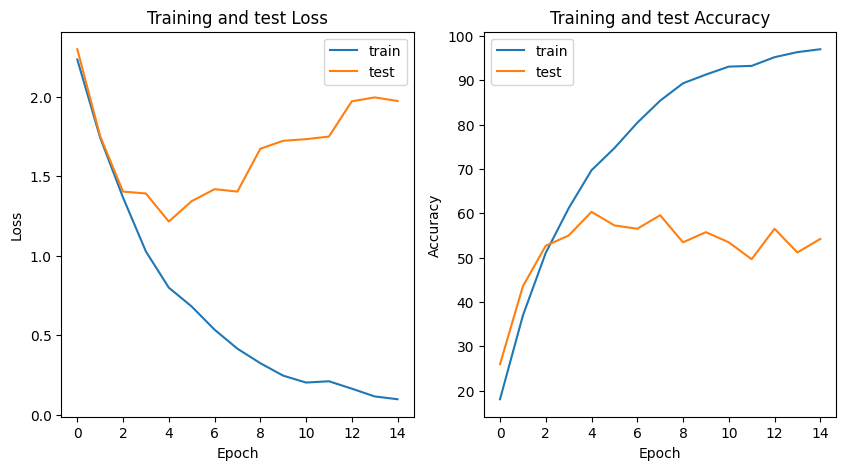

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and testing loss and accuracy values
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(train_losses, label='train')
ax[0].plot(test_losses, label='test')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training and test Loss')
ax[0].legend()
ax[1].plot(train_accs, label='train')
ax[1].plot(test_accs, label='test')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Training and test Accuracy')
ax[1].legend()
plt.show()

In [ ]:
# Calculate other metrics and the final test accuracy
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, classification_report
import pandas as pd
import numpy as np
import warnings
from sklearn.exceptions import UndefinedMetricWarning

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
    report = classification_report(y_true, y_pred, target_names=[str(i) for i in range(9)], digits=4)

conf_mat = confusion_matrix(y_true, y_pred)
roc_auc = roc_auc_score(np.array(pd.get_dummies(y_true)), y_scores, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Calculate other metrices
n_classes = conf_mat.shape[0]
tprs = []
specificity = 0
for i in range(n_classes):
    tp = conf_mat[i,i]
    fn = np.sum(conf_mat[i,:]) - tp
    fp = np.sum(conf_mat[:,i]) - tp
    tn = np.sum(conf_mat) - tp - fn - fp
    tpr = tp / (tp + fn)
    tprs.append(tpr)
sensitivity = np.mean(tprs)
test_accuracy /= 100

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"F1-score: {f1:.4f}")
print("Classification Report:")
print(report)

Test Loss: 1.9739
Test Accuracy: 0.5420
Sensitivity: 0.4798
ROC-AUC: 0.8411
F1-score: 0.4740
Classification Report:
              precision    recall  f1-score   support

           0     0.5962    0.5644    0.5799       225
           1     0.6434    0.7667    0.6996       240
           2     0.7197    0.4708    0.5693       240
           3     0.5194    0.4458    0.4798       240
           4     0.4974    0.4000    0.4434       240
           5     0.3535    0.4375    0.3911       240
           6     0.5950    0.7958    0.6809       240
           7     0.4070    0.4375    0.4217       240
           8     0.0000    0.0000    0.0000        60

    accuracy                         0.5232      1965
   macro avg     0.4813    0.4798    0.4740      1965
weighted avg     0.5245    0.5232    0.5166      1965



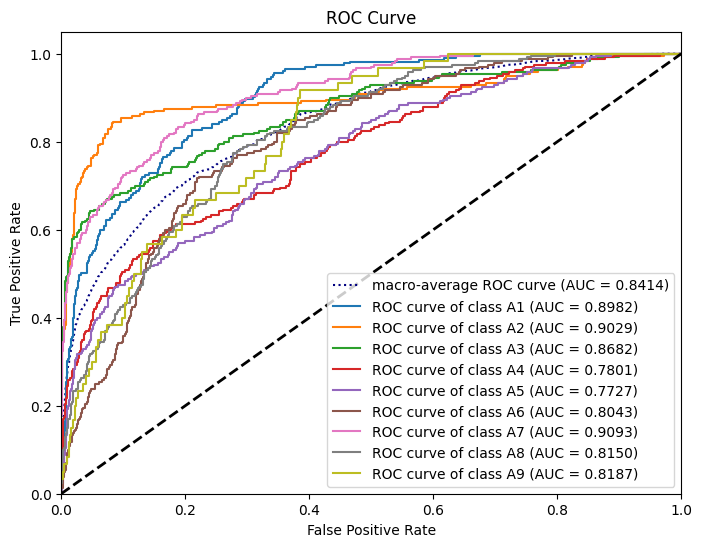

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Define a dictionary mapping class indices to class names
class_dict = {0: 'A1', 1: 'A2', 2: 'A3', 3: 'A4', 4: 'A5', 5: 'A6', 6: 'A7', 7: 'A8', 8:'A9'}

# Convert the y_true and y_scores lists to arrays
y_true = np.array(y_true)
y_scores = np.array(y_scores)

# Calculate the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(np.unique(y_true))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve((y_true == i).astype(int), y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr["macro"], tpr["macro"], label='macro-average ROC curve (AUC = {0:0.4f})'.format(roc_auc["macro"]), color='navy', linestyle=':')

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (AUC = {1:0.4f})'.format(class_dict[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

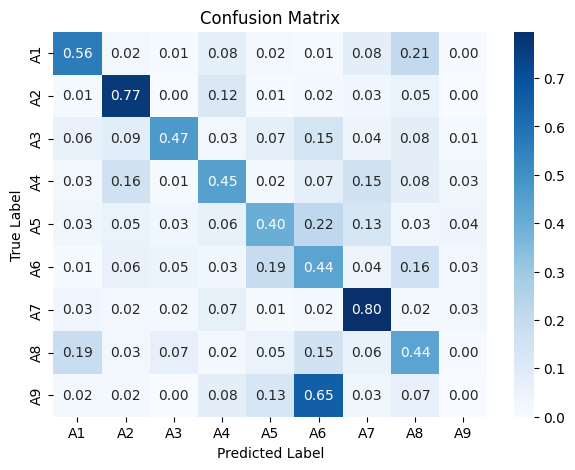

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a dictionary mapping class indices to class names
class_dict = {0: 'A1', 1: 'A2', 2: 'A3', 3: 'A4', 4: 'A5', 5: 'A6', 6: 'A7', 7: 'A8', 8:'A9'}

# Plot confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(conf_mat / conf_mat.sum(axis=1)[:, np.newaxis], annot=True, fmt='.2f', cmap=plt.cm.Blues, ax=ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix')
class_labels = sorted(list(class_dict.keys()), key=lambda x: int(x))
ax.xaxis.set_ticklabels([class_dict[label] for label in class_labels])
ax.yaxis.set_ticklabels([class_dict[label] for label in class_labels])
plt.show()